In [18]:
# Read and Inspect HDF5 Dataset
# This notebook helps you explore the structure and content of HDF5 demonstration datasets

import h5py
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# Configuration
DATASET_PATH = "./datasets/generated_dataset_ik_abs.hdf5"  # Change this to your dataset path

# Other options:
# DATASET_PATH = "./datasets/dataset.hdf5"              # Original teleoperation recordings
# DATASET_PATH = "./datasets/annotated_dataset.hdf5"    # Annotated with subtask signals (has datagen_info)
# DATASET_PATH = "./datasets/generated_dataset_ik_abs.hdf5"  # Generated IK Abs data (no datagen_info)

print(f"Reading dataset: {DATASET_PATH}")
print("=" * 70)
print("\n📝 Dataset Types:")
print("  - dataset.hdf5: Original teleoperation recordings (joint control)")
print("  - annotated_dataset.hdf5: Annotated with subtask signals (✅ has datagen_info)")
print("  - generated_dataset_ik_abs.hdf5: Generated IK Abs trajectories (❌ no datagen_info)")
print("\n💡 Note: Only annotated datasets contain 'datagen_info' with subtask signals.")
print("   Use 'annotated_dataset.hdf5' for analyzing subtask transitions (cells 6 & 9).")
print("=" * 70)

Reading dataset: ./datasets/generated_dataset_ik_abs.hdf5

📝 Dataset Types:
  - dataset.hdf5: Original teleoperation recordings (joint control)
  - annotated_dataset.hdf5: Annotated with subtask signals (✅ has datagen_info)
  - generated_dataset_ik_abs.hdf5: Generated IK Abs trajectories (❌ no datagen_info)

💡 Note: Only annotated datasets contain 'datagen_info' with subtask signals.
   Use 'annotated_dataset.hdf5' for analyzing subtask transitions (cells 6 & 9).


In [19]:
# 1. Check file structure
def print_hdf5_structure(name, obj, indent=0, max_depth=3):
    """Recursively print HDF5 file structure."""
    if indent > max_depth:
        return
    
    prefix = "  " * indent
    
    if isinstance(obj, h5py.Group):
        print(f"{prefix}📁 {name}/")
        for key in sorted(obj.keys()):
            print_hdf5_structure(key, obj[key], indent + 1, max_depth)
    elif isinstance(obj, h5py.Dataset):
        shape = obj.shape
        dtype = obj.dtype
        size_mb = obj.nbytes / (1024 * 1024)
        print(f"{prefix}📄 {name}: shape={shape}, dtype={dtype}, size={size_mb:.2f}MB")

with h5py.File(DATASET_PATH, 'r') as f:
    print("Dataset Structure:")
    print_hdf5_structure("root", f)


Dataset Structure:
📁 root/
  📁 data/
    📁 demo_0/
      📄 actions: shape=(174, 8), dtype=float32, size=0.01MB
      📁 initial_state/
      📁 obs/
      📄 processed_actions: shape=(174, 8), dtype=float32, size=0.01MB
      📁 states/
    📁 demo_1/
      📄 actions: shape=(161, 8), dtype=float32, size=0.00MB
      📁 initial_state/
      📁 obs/
      📄 processed_actions: shape=(161, 8), dtype=float32, size=0.00MB
      📁 states/
    📁 demo_2/
      📄 actions: shape=(371, 8), dtype=float32, size=0.01MB
      📁 initial_state/
      📁 obs/
      📄 processed_actions: shape=(371, 8), dtype=float32, size=0.01MB
      📁 states/


In [20]:
# 2. List all demonstrations
with h5py.File(DATASET_PATH, 'r') as f:
    if 'data' in f:
        demo_keys = sorted([k for k in f['data'].keys() if k.startswith('demo_')])
        print(f"Found {len(demo_keys)} demonstrations:")
        for i, demo_key in enumerate(demo_keys):
            demo = f[f'data/{demo_key}']
            if 'actions' in demo:
                num_steps = demo['actions'].shape[0]
                print(f"  {i+1}. {demo_key}: {num_steps} steps")
        print(f"\nTotal demos: {len(demo_keys)}")


Found 3 demonstrations:
  1. demo_0: 174 steps
  2. demo_1: 161 steps
  3. demo_2: 371 steps

Total demos: 3


In [21]:
# 3. Inspect first demonstration in detail
demo_idx = 0  # Change this to inspect different demos

with h5py.File(DATASET_PATH, 'r') as f:
    if 'data' in f:
        demo_keys = sorted([k for k in f['data'].keys() if k.startswith('demo_')])
        if demo_idx < len(demo_keys):
            demo_name = demo_keys[demo_idx]
            demo = f[f'data/{demo_name}']
            
            print(f"=== Inspecting {demo_name} ===")
            print(f"\nKeys: {list(demo.keys())}")
            
            # Check actions
            if 'actions' in demo:
                actions = np.array(demo['actions'])
                print(f"\nActions:")
                print(f"  Shape: {actions.shape}")
                print(f"  Dtype: {actions.dtype}")
                print(f"  Range: [{actions.min():.4f}, {actions.max():.4f}]")
                print(f"  Mean: {actions.mean(axis=0)}")
                print(f"  First action: {actions[0]}")
                print(f"  Last action: {actions[-1]}")
            
            # Check observations
            if 'obs' in demo:
                obs = demo['obs']
                print(f"\nObservations:")
                print(f"  Keys: {list(obs.keys())}")
                for key in obs.keys():
                    val = obs[key]
                    if isinstance(val, h5py.Dataset):
                        print(f"    {key}: shape={val.shape}, dtype={val.dtype}")
                        if val.shape[0] > 0:
                            print(f"      First value: {np.array(val[0])}")
                        
                        # Explain object observation dimensions
                        if key == 'object' and val.shape[1] == 10:
                            print(f"      [Explanation] object shape=10 means:")
                            print(f"        - cube_pos (3 dim): cube position relative to env origin")
                            print(f"        - cube_quat (4 dim): cube orientation quaternion (w, x, y, z)")
                            print(f"        - gripper_to_cube (3 dim): vector from gripper to cube")
                            print(f"        Total: 3 + 4 + 3 = 10 dimensions")
            
            # Check subtask signals
            if 'obs' in demo and 'datagen_info' in demo['obs']:
                datagen_info = demo['obs']['datagen_info']
                if 'subtask_term_signals' in datagen_info:
                    signals = datagen_info['subtask_term_signals']
                    print(f"\nSubtask Signals:")
                    for subtask_name in signals.keys():
                        signal = np.array(signals[subtask_name])
                        completed_steps = np.sum(signal)
                        print(f"  {subtask_name}: {completed_steps}/{len(signal)} steps completed")
                        # Find transition points
                        transitions = np.where(np.diff(signal.astype(int)) > 0)[0]
                        if len(transitions) > 0:
                            print(f"    Completed at step: {transitions[0]}")


=== Inspecting demo_0 ===

Keys: ['actions', 'initial_state', 'obs', 'processed_actions', 'states']

Actions:
  Shape: (174, 8)
  Dtype: float32
  Range: [-0.7455, 4.2452]
  Mean: [ 4.042572    0.06236423  0.06545364  0.47813246  0.01769653 -0.10254685
 -0.1038257  -0.7431696 ]
  First action: [ 1.0851057   0.12496407  0.08178239  0.5478926   0.5783653  -0.41778496
 -0.43676418 -0.74551404]
  Last action: [ 4.0699015   0.03085991  0.08393461 -0.52421314  0.05845909 -0.03800817
  0.8487276  -0.74551404]

Observations:
  Keys: ['actions', 'eef_pos', 'eef_quat', 'gripper_pos', 'joint_pos', 'joint_vel', 'object', 'object_orientations', 'object_positions']
    actions: shape=(174, 8), dtype=float32
      First value: [0. 0. 0. 0. 0. 0. 0. 0.]
    eef_pos: shape=(174, 3), dtype=float32
      First value: [0.45308018 0.12669191 0.05264317]
    eef_quat: shape=(174, 4), dtype=float32
      First value: [-0.46943796 -0.6491016   0.32241195  0.5043271 ]
    gripper_pos: shape=(174, 1), dtype=flo

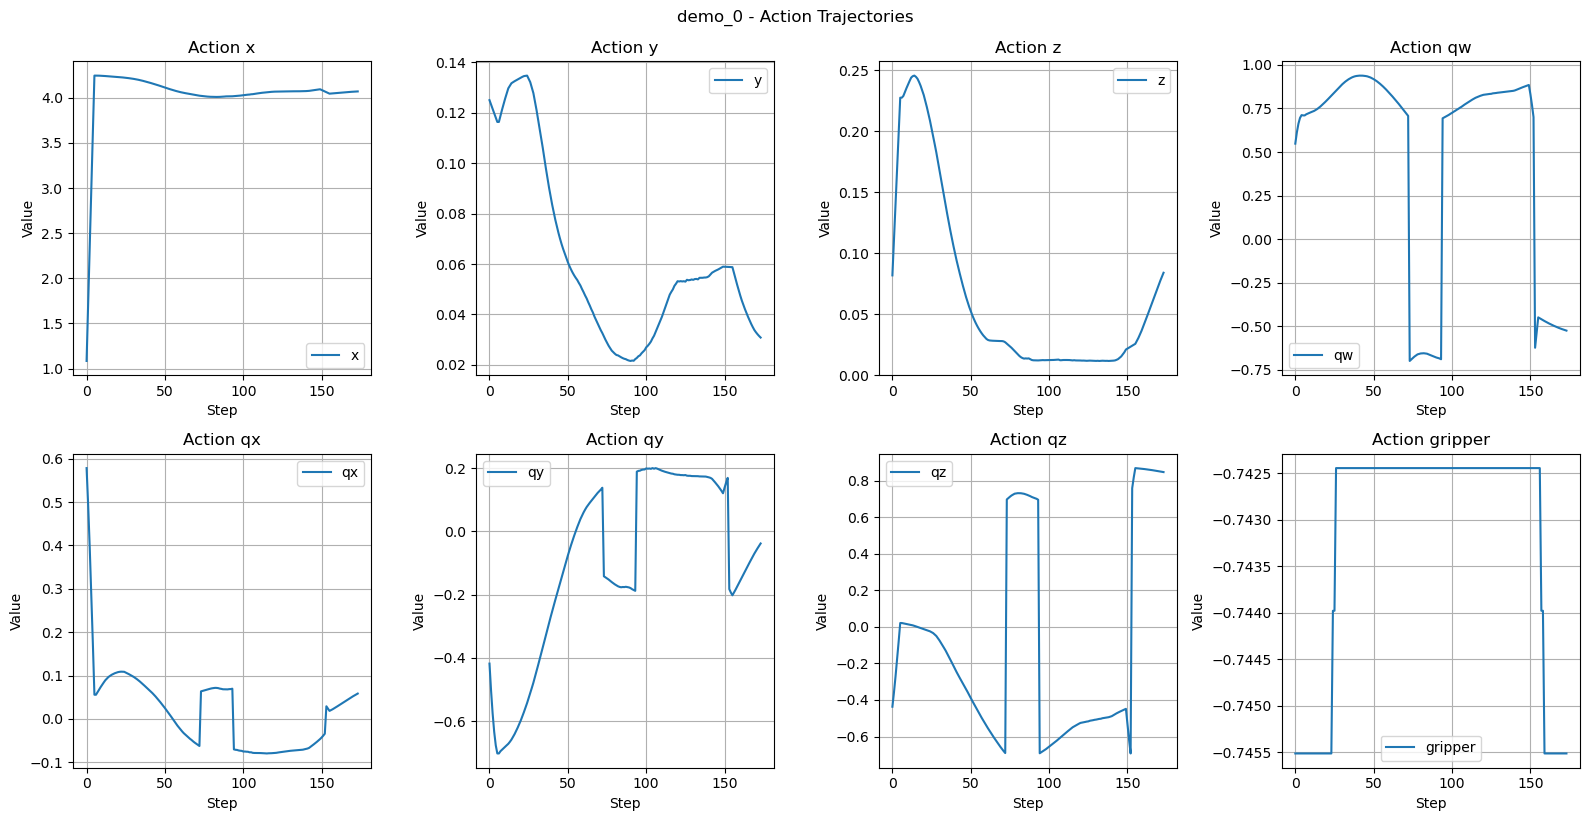

Action statistics for demo_0:
  Steps: 174
  Dimensions: 8
    x: min=1.0851, max=4.2452, mean=4.0426
    y: min=0.0216, max=0.1347, mean=0.0624
    z: min=0.0116, max=0.2456, mean=0.0655
    qw: min=-0.6982, max=0.9382, mean=0.4781
    qx: min=-0.0796, max=0.5784, mean=0.0177
    qy: min=-0.7018, max=0.2002, mean=-0.1025
    qz: min=-0.6929, max=0.8706, mean=-0.1038
    gripper: min=-0.7455, max=-0.7424, mean=-0.7432


In [22]:
# 4. Visualize action trajectories
demo_idx = 0  # Change this to visualize different demos

with h5py.File(DATASET_PATH, 'r') as f:
    if 'data' in f:
        demo_keys = sorted([k for k in f['data'].keys() if k.startswith('demo_')])
        if demo_idx < len(demo_keys):
            demo_name = demo_keys[demo_idx]
            demo = f[f'data/{demo_name}']
            
            if 'actions' in demo:
                actions = np.array(demo['actions'])
                
                # Plot action trajectories
                fig, axes = plt.subplots(2, 4, figsize=(16, 8))
                axes = axes.flatten()
                
                action_labels = ['x', 'y', 'z', 'qw', 'qx', 'qy', 'qz', 'gripper']
                
                for i in range(min(8, actions.shape[1])):
                    ax = axes[i]
                    ax.plot(actions[:, i], label=action_labels[i] if i < len(action_labels) else f'dim_{i}')
                    ax.set_title(f'Action {action_labels[i] if i < len(action_labels) else f"dim_{i}"}')
                    ax.set_xlabel('Step')
                    ax.set_ylabel('Value')
                    ax.grid(True)
                    ax.legend()
                
                plt.tight_layout()
                plt.suptitle(f'{demo_name} - Action Trajectories', y=1.02)
                plt.show()
                
                print(f"Action statistics for {demo_name}:")
                print(f"  Steps: {actions.shape[0]}")
                print(f"  Dimensions: {actions.shape[1]}")
                for i in range(min(8, actions.shape[1])):
                    label = action_labels[i] if i < len(action_labels) else f'dim_{i}'
                    print(f"    {label}: min={actions[:, i].min():.4f}, max={actions[:, i].max():.4f}, mean={actions[:, i].mean():.4f}")


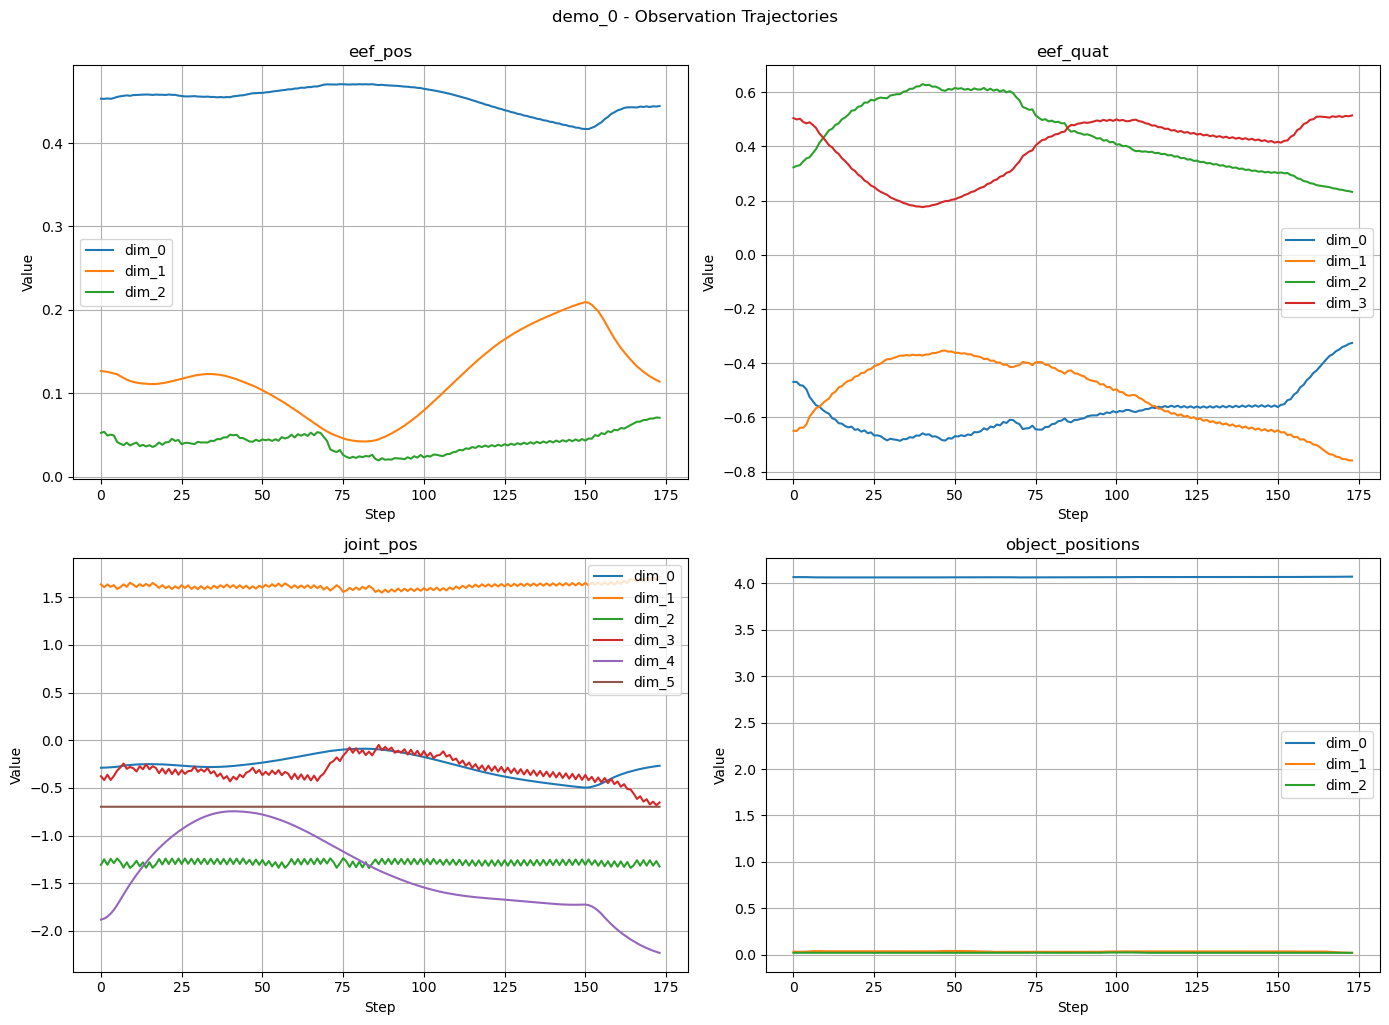

In [23]:
# 5. Visualize observation trajectories
demo_idx = 0  # Change this to visualize different demos

with h5py.File(DATASET_PATH, 'r') as f:
    if 'data' in f:
        demo_keys = sorted([k for k in f['data'].keys() if k.startswith('demo_')])
        if demo_idx < len(demo_keys):
            demo_name = demo_keys[demo_idx]
            demo = f[f'data/{demo_name}']
            
            if 'obs' in demo:
                obs = demo['obs']
                
                # Plot key observations
                key_obs = ['eef_pos', 'eef_quat', 'joint_pos', 'object_positions']
                
                fig, axes = plt.subplots(2, 2, figsize=(14, 10))
                axes = axes.flatten()
                
                for idx, key in enumerate(key_obs):
                    if key in obs:
                        ax = axes[idx]
                        data = np.array(obs[key])
                        
                        if len(data.shape) == 2:
                            for dim in range(data.shape[1]):
                                ax.plot(data[:, dim], label=f'dim_{dim}')
                        else:
                            ax.plot(data, label=key)
                        
                        ax.set_title(f'{key}')
                        ax.set_xlabel('Step')
                        ax.set_ylabel('Value')
                        ax.grid(True)
                        ax.legend()
                
                plt.tight_layout()
                plt.suptitle(f'{demo_name} - Observation Trajectories', y=1.02)
                plt.show()


In [24]:
# 6. Analyze subtask transitions
demo_idx = 0  # Change this to analyze different demos

with h5py.File(DATASET_PATH, 'r') as f:
    if 'data' in f:
        demo_keys = sorted([k for k in f['data'].keys() if k.startswith('demo_')])
        if demo_idx < len(demo_keys):
            demo_name = demo_keys[demo_idx]
            demo = f[f'data/{demo_name}']
            
            print(f"=== Analyzing subtask transitions for {demo_name} ===")
            
            # Check if datagen_info exists
            if 'obs' not in demo:
                print("❌ No 'obs' key found in demo")
            elif 'datagen_info' not in demo['obs']:
                print("❌ No 'datagen_info' found in obs")
                print("\n💡 Note: datagen_info is only available in annotated datasets.")
                print("   Try using: DATASET_PATH = './datasets/annotated_dataset.hdf5'")
                print(f"\nAvailable keys in obs: {list(demo['obs'].keys())}")
            else:
                datagen_info = demo['obs']['datagen_info']
                print(f"✅ Found datagen_info with keys: {list(datagen_info.keys())}")
                
                if 'subtask_term_signals' not in datagen_info:
                    print("❌ No 'subtask_term_signals' found in datagen_info")
                else:
                    signals = datagen_info['subtask_term_signals']
                    print(f"✅ Found subtask signals: {list(signals.keys())}")
                    
                    # Plot subtask signals
                    fig, axes = plt.subplots(len(signals), 1, figsize=(12, 4 * len(signals)))
                    if len(signals) == 1:
                        axes = [axes]
                    
                    for idx, (subtask_name, signal_dataset) in enumerate(signals.items()):
                        signal = np.array(signal_dataset)
                        ax = axes[idx]
                        
                        # Plot signal
                        ax.plot(signal.astype(float), label=subtask_name, linewidth=2)
                        ax.set_title(f'Subtask Signal: {subtask_name}')
                        ax.set_xlabel('Step')
                        ax.set_ylabel('Completed (1) / Not Completed (0)')
                        ax.set_ylim(-0.1, 1.1)
                        ax.grid(True)
                        ax.legend()
                        
                        # Mark transition points
                        transitions = np.where(np.diff(signal.astype(int)) > 0)[0]
                        if len(transitions) > 0:
                            for trans in transitions:
                                ax.axvline(x=trans, color='r', linestyle='--', alpha=0.5, label='Completion' if trans == transitions[0] else '')
                            print(f"\n{subtask_name} completed at step: {transitions[0]}")
                        else:
                            print(f"\n{subtask_name} was never completed in this demo")
                    
                    plt.tight_layout()
                    plt.suptitle(f'{demo_name} - Subtask Signals', y=1.02)
                    plt.show()
                    
                    # Determine active subtask at each step
                    subtask_order = list(signals.keys())
                    active_subtasks = []
                    for i in range(len(signal)):
                        active_idx = None
                        for idx, subtask_name in enumerate(subtask_order):
                            if not np.array(signals[subtask_name])[i]:
                                active_idx = idx
                                break
                        if active_idx is None:
                            active_idx = len(subtask_order) - 1
                        active_subtasks.append(active_idx)
                    
                    print(f"\nActive subtask distribution:")
                    for idx, subtask_name in enumerate(subtask_order):
                        count = sum(1 for a in active_subtasks if a == idx)
                        print(f"  {subtask_name}: {count} steps ({count/len(active_subtasks)*100:.1f}%)")
        else:
            print(f"Demo index {demo_idx} out of range (total: {len(demo_keys)})")
    else:
        print("No 'data' key found in dataset")


=== Analyzing subtask transitions for demo_0 ===
❌ No 'datagen_info' found in obs

💡 Note: datagen_info is only available in annotated datasets.
   Try using: DATASET_PATH = './datasets/annotated_dataset.hdf5'

Available keys in obs: ['actions', 'eef_pos', 'eef_quat', 'gripper_pos', 'joint_pos', 'joint_vel', 'object', 'object_orientations', 'object_positions']


=== Comparison across all demos ===

Demo lengths: [174, 161, 371]
  Min: 161 steps
  Max: 371 steps
  Mean: 235.3 steps
  Std: 96.1 steps


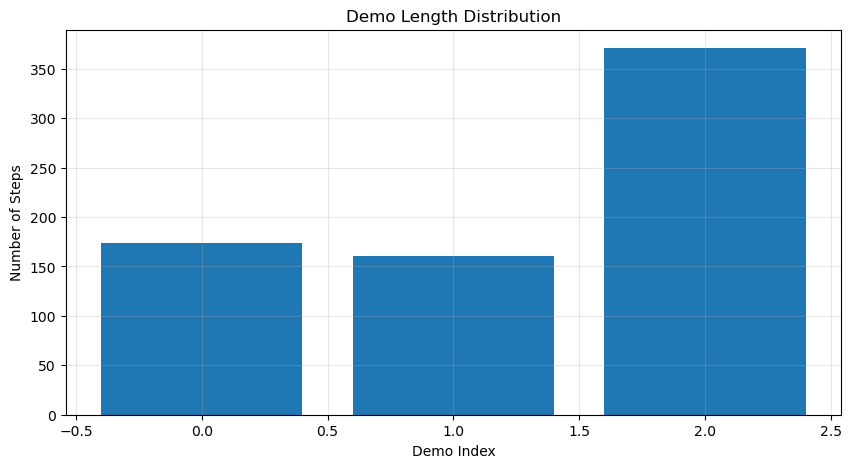

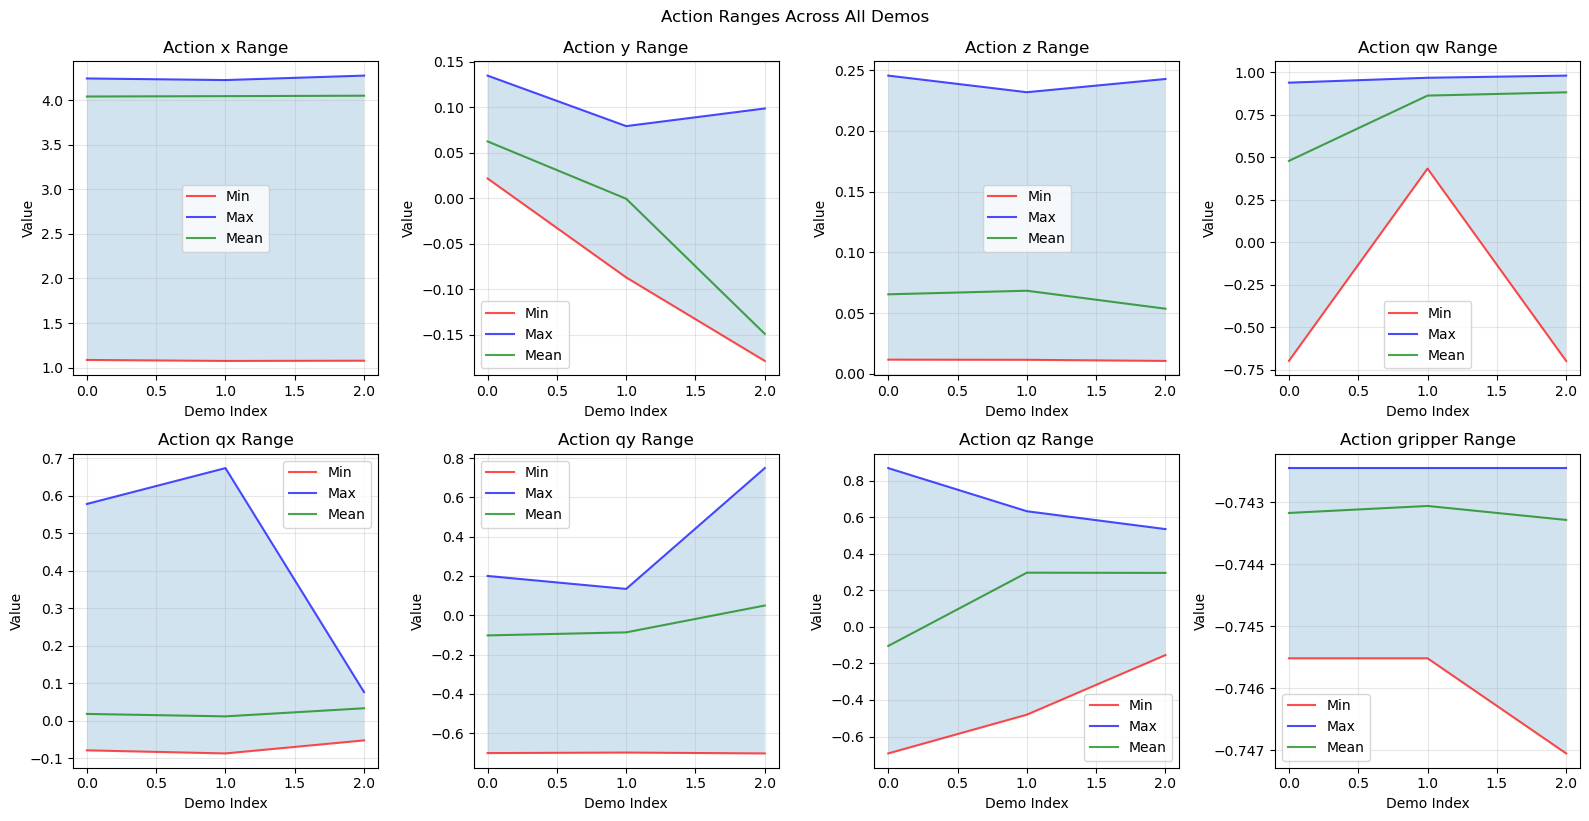

In [25]:
# 7. Compare multiple demos
with h5py.File(DATASET_PATH, 'r') as f:
    if 'data' in f:
        demo_keys = sorted([k for k in f['data'].keys() if k.startswith('demo_')])
        
        print("=== Comparison across all demos ===")
        
        # Collect statistics
        demo_lengths = []
        action_ranges = []
        
        for demo_name in demo_keys:
            demo = f[f'data/{demo_name}']
            if 'actions' in demo:
                actions = np.array(demo['actions'])
                demo_lengths.append(actions.shape[0])
                action_ranges.append({
                    'min': actions.min(axis=0),
                    'max': actions.max(axis=0),
                    'mean': actions.mean(axis=0),
                })
        
        print(f"\nDemo lengths: {demo_lengths}")
        print(f"  Min: {min(demo_lengths)} steps")
        print(f"  Max: {max(demo_lengths)} steps")
        print(f"  Mean: {np.mean(demo_lengths):.1f} steps")
        print(f"  Std: {np.std(demo_lengths):.1f} steps")
        
        # Plot demo length distribution
        plt.figure(figsize=(10, 5))
        plt.bar(range(len(demo_lengths)), demo_lengths)
        plt.xlabel('Demo Index')
        plt.ylabel('Number of Steps')
        plt.title('Demo Length Distribution')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Plot action range across all demos
        if action_ranges:
            action_labels = ['x', 'y', 'z', 'qw', 'qx', 'qy', 'qz', 'gripper']
            fig, axes = plt.subplots(2, 4, figsize=(16, 8))
            axes = axes.flatten()
            
            for i in range(min(8, len(action_ranges[0]['min']))):
                ax = axes[i]
                mins = [r['min'][i] for r in action_ranges]
                maxs = [r['max'][i] for r in action_ranges]
                means = [r['mean'][i] for r in action_ranges]
                
                ax.plot(mins, 'r-', label='Min', alpha=0.7)
                ax.plot(maxs, 'b-', label='Max', alpha=0.7)
                ax.plot(means, 'g-', label='Mean', alpha=0.7)
                ax.fill_between(range(len(mins)), mins, maxs, alpha=0.2)
                ax.set_title(f'Action {action_labels[i] if i < len(action_labels) else f"dim_{i}"} Range')
                ax.set_xlabel('Demo Index')
                ax.set_ylabel('Value')
                ax.grid(True, alpha=0.3)
                ax.legend()
            
            plt.tight_layout()
            plt.suptitle('Action Ranges Across All Demos', y=1.02)
            plt.show()


In [26]:
# 8. Extract and save specific demo data for analysis
demo_idx = 0  # Change this to extract different demos
save_to_numpy = False  # Set to True to save as numpy files

with h5py.File(DATASET_PATH, 'r') as f:
    if 'data' in f:
        demo_keys = sorted([k for k in f['data'].keys() if k.startswith('demo_')])
        if demo_idx < len(demo_keys):
            demo_name = demo_keys[demo_idx]
            demo = f[f'data/{demo_name}']
            
            # Extract data
            data_dict = {}
            
            if 'actions' in demo:
                data_dict['actions'] = np.array(demo['actions'])
            
            if 'obs' in demo:
                obs = demo['obs']
                data_dict['observations'] = {}
                for key in obs.keys():
                    if isinstance(obs[key], h5py.Dataset):
                        data_dict['observations'][key] = np.array(obs[key])
                    elif isinstance(obs[key], h5py.Group):
                        # Handle nested groups (like datagen_info)
                        data_dict['observations'][key] = {}
                        for subkey in obs[key].keys():
                            if isinstance(obs[key][subkey], h5py.Dataset):
                                data_dict['observations'][key][subkey] = np.array(obs[key][subkey])
            
            # Print summary
            print(f"=== Extracted data from {demo_name} ===")
            print(f"Actions shape: {data_dict.get('actions', 'N/A')}")
            if 'observations' in data_dict:
                print(f"Observations keys: {list(data_dict['observations'].keys())}")
                for key, val in data_dict['observations'].items():
                    if isinstance(val, dict):
                        print(f"  {key}: {list(val.keys())}")
                    else:
                        print(f"  {key}: shape={val.shape if hasattr(val, 'shape') else 'N/A'}")
            
            # Save to numpy if requested
            if save_to_numpy:
                output_dir = Path("./extracted_data")
                output_dir.mkdir(exist_ok=True)
                np.savez(output_dir / f"{demo_name}_data.npz", **data_dict)
                print(f"\nSaved to: {output_dir / f'{demo_name}_data.npz'}")


=== Extracted data from demo_0 ===
Actions shape: [[ 1.0851057   0.12496407  0.08178239 ... -0.41778496 -0.43676418
  -0.74551404]
 [ 1.7171311   0.12323623  0.11092159 ... -0.5027888  -0.3583609
  -0.74551404]
 [ 2.3491566   0.12150839  0.14006081 ... -0.5753137  -0.27106336
  -0.74551404]
 ...
 [ 4.0678973   0.03218393  0.07760452 ... -0.05349948  0.85179514
  -0.74551404]
 [ 4.06892     0.03148457  0.08080944 ... -0.04563818  0.8502725
  -0.74551404]
 [ 4.0699015   0.03085991  0.08393461 ... -0.03800817  0.8487276
  -0.74551404]]
Observations keys: ['actions', 'eef_pos', 'eef_quat', 'gripper_pos', 'joint_pos', 'joint_vel', 'object', 'object_orientations', 'object_positions']
  actions: shape=(174, 8)
  eef_pos: shape=(174, 3)
  eef_quat: shape=(174, 4)
  gripper_pos: shape=(174, 1)
  joint_pos: shape=(174, 6)
  joint_vel: shape=(174, 6)
  object: shape=(174, 10)
  object_orientations: shape=(174, 4)
  object_positions: shape=(174, 3)


In [27]:
# 9. Check for subtask condition encoding (for training)
# This shows how subtask conditions would be determined from signals

demo_idx = 0  # Change this to check different demos

with h5py.File(DATASET_PATH, 'r') as f:
    if 'data' in f:
        demo_keys = sorted([k for k in f['data'].keys() if k.startswith('demo_')])
        if demo_idx < len(demo_keys):
            demo_name = demo_keys[demo_idx]
            demo = f[f'data/{demo_name}']
            
            print(f"=== Subtask Condition Encoding for {demo_name} ===")
            
            # Check if datagen_info exists
            if 'obs' not in demo:
                print("❌ No 'obs' key found in demo")
            elif 'datagen_info' not in demo['obs']:
                print("❌ No 'datagen_info' found in obs")
                print("\n💡 Note: datagen_info is only available in annotated datasets.")
                print("   Try using: DATASET_PATH = './datasets/annotated_dataset.hdf5'")
            else:
                datagen_info = demo['obs']['datagen_info']
                if 'subtask_term_signals' not in datagen_info:
                    print("❌ No 'subtask_term_signals' found in datagen_info")
                else:
                    signals = datagen_info['subtask_term_signals']
                    subtask_order = list(signals.keys())
                    
                    print(f"✅ Subtask order: {subtask_order}")
                    
                    # Determine active subtask at each step
                    num_steps = len(np.array(list(signals.values())[0]))
                    subtask_conditions = []
                    
                    for i in range(num_steps):
                        active_idx = None
                        for idx, subtask_name in enumerate(subtask_order):
                            if not np.array(signals[subtask_name])[i]:
                                active_idx = idx
                                break
                        if active_idx is None:
                            active_idx = len(subtask_order) - 1
                        
                        # One-hot encoding
                        condition = np.zeros(len(subtask_order))
                        condition[active_idx] = 1.0
                        subtask_conditions.append(condition)
                    
                    subtask_conditions = np.array(subtask_conditions)
                    
                    print(f"\nSubtask condition shape: {subtask_conditions.shape}")
                    print(f"First 10 conditions:")
                    for i in range(min(10, len(subtask_conditions))):
                        active_subtask = subtask_order[np.argmax(subtask_conditions[i])]
                        print(f"  Step {i}: {subtask_conditions[i]} -> {active_subtask}")
                    
                    # Visualize subtask transitions
                    active_indices = [np.argmax(c) for c in subtask_conditions]
                    plt.figure(figsize=(12, 4))
                    plt.plot(active_indices, 'o-', markersize=3)
                    plt.yticks(range(len(subtask_order)), subtask_order)
                    plt.xlabel('Step')
                    plt.ylabel('Active Subtask')
                    plt.title(f'{demo_name} - Active Subtask Over Time')
                    plt.grid(True, alpha=0.3)
                    plt.show()
        else:
            print(f"Demo index {demo_idx} out of range (total: {len(demo_keys)})")
    else:
        print("No 'data' key found in dataset")


=== Subtask Condition Encoding for demo_0 ===
❌ No 'datagen_info' found in obs

💡 Note: datagen_info is only available in annotated datasets.
   Try using: DATASET_PATH = './datasets/annotated_dataset.hdf5'
